<a href="https://colab.research.google.com/github/Parth-349/PRODIGY_GA_05/blob/main/GA_05_Output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Upload your content image (e.g., your photo)


Saving mohamed-jamil-latrach-WIrWXyYhq94-unsplash.jpg to mohamed-jamil-latrach-WIrWXyYhq94-unsplash (1).jpg
 Upload your style image (e.g., a painting)


Saving The_Great_Wave_off_Kanagawa.jpg to The_Great_Wave_off_Kanagawa.jpg


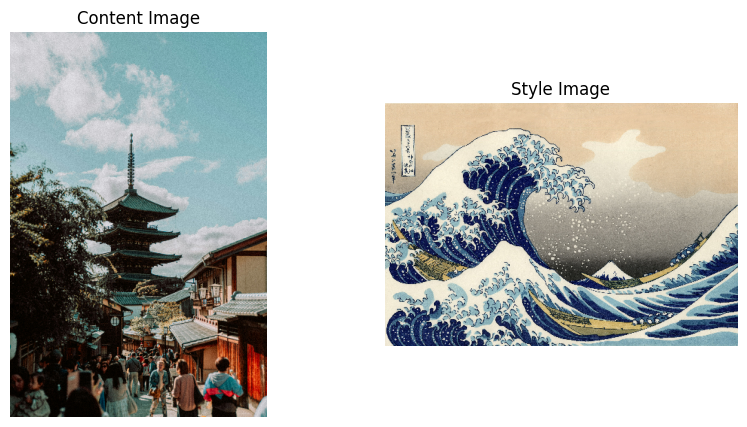

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 353, 512, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 512, 341, 3))
  warnings.warn(msg)


 Training...
 Epoch 1/10 complete
 Epoch 2/10 complete
 Epoch 3/10 complete
 Epoch 4/10 complete
 Epoch 5/10 complete
 Epoch 6/10 complete
 Epoch 7/10 complete
 Epoch 8/10 complete
 Epoch 9/10 complete
 Epoch 10/10 complete

 Total training time: 699.1 seconds


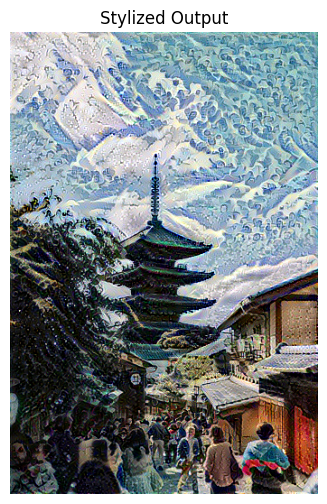

 Saved output as stylized_image.png


In [1]:
#  STEP 1: Install dependencies
!pip install -q tensorflow matplotlib

#  STEP 2: Import libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import time
from google.colab import files

#  STEP 3: Upload content image
print(" Upload your content image (e.g., your photo)")
content_upload = files.upload()
content_path = list(content_upload.keys())[0]

#  STEP 4: Upload style image
print(" Upload your style image (e.g., a painting)")
style_upload = files.upload()
style_path = list(style_upload.keys())[0]

#  STEP 5: Image processing functions
def load_img(path):
    max_dim = 512
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    return img[tf.newaxis, :]

def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

#  STEP 6: Load and display input images
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(tf.squeeze(content_image))
plt.title("Content Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(tf.squeeze(style_image))
plt.title("Style Image")
plt.axis('off')
plt.show()

#  STEP 7: Load VGG model
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1',
                'block4_conv1', 'block5_conv1']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

def vgg_layers(layer_names):
    outputs = [vgg.get_layer(name).output for name in layer_names]
    return tf.keras.Model([vgg.input], outputs)

def gram_matrix(tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', tensor, tensor)
    shape = tf.shape(tensor)
    num_locations = tf.cast(shape[1] * shape[2], tf.float32)
    return result / num_locations

#  STEP 8: StyleContentModel definition
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super().__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs = outputs[:len(self.style_layers)]
        content_outputs = outputs[len(self.style_layers):]
        style_outputs = [gram_matrix(output) for output in style_outputs]
        style_dict = {name: value for name, value in zip(self.style_layers, style_outputs)}
        content_dict = {name: value for name, value in zip(self.content_layers, content_outputs)}
        return {"style": style_dict, "content": content_dict}

#  STEP 9: Set up model and training variables
extractor = StyleContentModel(style_layers, content_layers)
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']
image = tf.Variable(content_image)

opt = tf.keras.optimizers.Adam(learning_rate=0.02)
style_weight = 1e-2
content_weight = 1e4

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        style_output = outputs['style']
        content_output = outputs['content']

        style_loss = tf.add_n([tf.reduce_mean((style_output[name] - style_targets[name])**2)
                               for name in style_output])
        style_loss *= style_weight / num_style_layers

        content_loss = tf.add_n([tf.reduce_mean((content_output[name] - content_targets[name])**2)
                                 for name in content_output])
        content_loss *= content_weight / num_content_layers

        loss = style_loss + content_loss

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(tf.clip_by_value(image, 0.0, 1.0))

#  STEP 10: Training loop
print(" Training...")
start = time.time()

epochs = 10
steps_per_epoch = 10
step = 0

for n in range(epochs):
    for m in range(steps_per_epoch):
        train_step(image)
        step += 1
    print(f" Epoch {n+1}/{epochs} complete")

print(f"\n Total training time: {time.time() - start:.1f} seconds")

#  STEP 11: Show and save output image
stylized_img = tensor_to_image(image)

plt.figure(figsize=(6, 6))
plt.imshow(stylized_img)
plt.title("Stylized Output")
plt.axis('off')
plt.show()

stylized_img.save("stylized_image.png")
print(" Saved output as stylized_image.png")
